## Ballistic Noise Model
* Characterized by straight lines of Pauli errors
* Introduce bit-flip error on edge $j$ and on $\xi - 1$ errors to right of edge $j$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, choose_gauge_fixing, random_pauli, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

In [2]:
def pauli_mul_rules(p_1: str, p_2: str):
    if (p_1 == p_2):
        return 'I' 
    elif (p_1 == 'X' and p_2 == 'Z' or p_1 == 'Z' and p_2 == 'X'):
        return 'Y' 
    elif (p_1 == 'X' and p_2 == 'Y' or p_1 == 'Y' and p_2 == 'X'):
        return 'Z' 
    elif (p_1 == 'Y' and p_2 == 'Z' or p_1 == 'Z' and p_2 == 'Y'):
        return 'X'
    elif ((p_1 == 'X' or p_1 == 'Y' or p_1 == 'Z') and p_2 == 'I'):
        return p_1 
    elif ((p_2 == 'X' or p_2 == 'Y' or p_2 == 'Z') and p_1 == 'I'):
        return p_2
    
def choose_error_locs(lat: Lattice2D, num_errors: int, error_prob) -> List[Tuple]:
    dimX = lat.dimX 
    dimZ = lat.dimZ 
    err = []
    for _ in range(num_errors):
        error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
        error_type = np.random.choice(['X', 'Y', 'Z'])
        if np.random.binomial(1, error_prob):
            err.append(error_loc)
    return err


class BallisticNoiseModel():
    def __init__(self, p: float, xi: int):
        self.p = p 
        self.xi = xi 

    def sample_error(self, p: float, lat: Lattice2D, decay: float, dir: str = None):
        if (dir == None):
            dir = np.random.choice(['U', 'D', 'L', 'R'])
        # print(dir)
        dimX = lat.dimX 
        dimZ = lat.dimZ 
        self.p = p 
        curr_p = self.p 
        error = np.zeros((dimX, dimZ), dtype=str)
        for i in range(dimX):
            for j in range(dimZ):
                error[i][j] = 'I' 
        # error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
        # print("START: " + str(error_loc))
        error_type = np.random.choice(['X', 'Y', 'Z'])
        # print("ERROR TYPE: " + str(error_type))
        error_locs = choose_error_locs(lat, int(dimZ/2), curr_p)
        if len(error_locs) == 0:
            error_str = '' 
            for r in error:
                for e in r:
                    error_str += e 
            return error, pauli2vector(error_str)
        for error_loc in error_locs:
            curr_p = self.p
            for i in range(self.xi):
                curr_p *= decay 
                if (dir == 'U' and np.random.binomial(1, curr_p) and error_loc[0] - (i + 1) >= 0):
                    error[error_loc[0] - (i + 1)][error_loc[1]] = pauli_mul_rules(error[error_loc[0] - (i + 1)][error_loc[1]], error_type)
                    # print(error_loc[0] - (i + 1), error_loc[1])
                elif (dir == 'D' and np.random.binomial(1, curr_p) and error_loc[0] + (i + 1) < dimX):
                    error[error_loc[0] + (i + 1)][error_loc[1]] = pauli_mul_rules(error[error_loc[0] + (i + 1)][error_loc[1]], error_type)
                    # print(error_loc[0] + (i + 1), error_loc[1])
                elif (dir == 'L' and np.random.binomial(1, curr_p) and error_loc[1] - (i + 1) >= 0):
                    error[error_loc[0]][error_loc[1] - (i + 1)] = pauli_mul_rules(error[error_loc[0]][error_loc[1] - (i + 1)], error_type)
                    # print(error_loc[0], error_loc[1] - (i + 1))
                elif (dir == 'R' and np.random.binomial(1, curr_p) and error_loc[1] + (i + 1) < dimZ):
                    error[error_loc[0]][error_loc[1] + (i + 1)] = pauli_mul_rules(error[error_loc[0]][error_loc[1] + (i + 1)], error_type)
                    # print(error_loc[0], error_loc[1] + (i + 1))
                else:
                    break

        error_str = '' 
        for r in error:
            for e in r:
                error_str += e 
        return error, pauli2vector(error_str)


    # class DiffusiveNoiseModel():
#     def __init__(self, p: float, xi: int):
#         self.p = p 
#         self.xi = xi 

#     def random_walk(start_pos: tuple, num_steps: int, dimX: int, dimZ: int):
        


#     def sample_error(self, p: float, lat: Lattice2D, decay: float):
#         dimX = lat.dimX
#         dimZ = lat.dimZ
#         self.p = p 
#         error = np.zeros((dimX, dimZ), dtype=str)
#         for i in range(dimX):
#             for j in range(dimZ):
#                 error[i][j] = 'I'
#         error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
#         while ((dir == 'U' and error_loc[0] - self.xi < 0)
#             or (dir == 'D' and error_loc[0] + self.xi > dimZ - 1)
#             or (dir == 'L' and error_loc[1] - self.xi < 0)
#             or (dir == 'R' and error_loc[1] + self.xi > dimX - 1)):
#                 error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
#         error_type = np.random.choice(['X', 'Y', 'Z'])
#         error[error_loc[0]][error_loc[1]] = error_type


In [17]:
lat = Lattice2D(7,7)
k = 2
bnm = BallisticNoiseModel(0.1, lat.dimX//k)
pauli_error, symplectic_form = bnm.sample_error(0.5,lat, 0.95, dir='R')
pauli_error


array([['I', 'I', 'I', 'I', 'I', 'I', 'I'],
       ['I', 'I', 'I', 'I', 'I', 'I', 'I'],
       ['I', 'I', 'I', 'I', 'I', 'I', 'I'],
       ['I', 'I', 'I', 'I', 'Y', 'Y', 'Y'],
       ['I', 'I', 'I', 'I', 'I', 'I', 'I'],
       ['I', 'I', 'I', 'I', 'I', 'I', 'I'],
       ['I', 'I', 'I', 'I', 'I', 'I', 'I']], dtype='<U1')

## Ballistic Noise Model - Fixed Direction + BP+OSD
* $\xi = 3$ - Length of error chain
* $\gamma = 0.95$ - Error rate decay

In [416]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//3)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                # weightsX = bpd_X.log_prob_ratios 
                # if (np.max(weightsX) > 20000000):
                #     weightsX = np.zeros((lat.size(),))
                # weightsZ = bpd_Z.log_prob_ratios
                # if (np.max(weightsZ) > 20000000):
                #     weightsZ = np.zeros((lat.size(),))
                # decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                # decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                # recoveryX = decodingX.decode(syndromeZ)
                # recoveryZ = decodingZ.decode(syndromeX)
                # recovery = np.concatenate((recoveryZ, recoveryX))
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:49<00:00, 88.31s/it] 


In [417]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

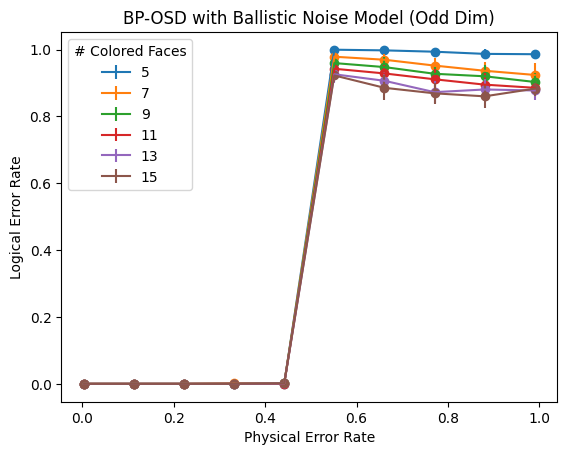

In [418]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

In [419]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 40
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 200
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//2)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [26:50<00:00, 268.45s/it]


In [420]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

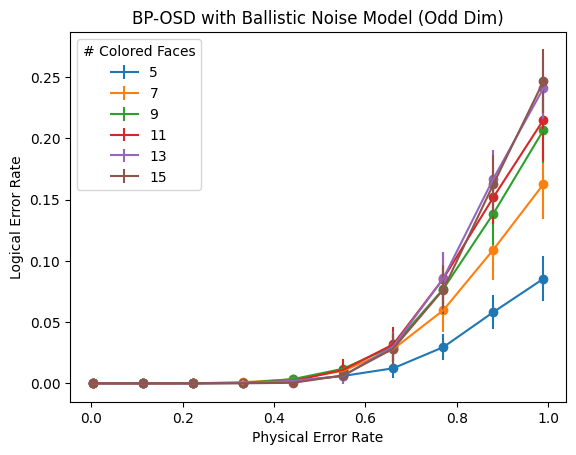

In [421]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

### Comparison with Surface Code

In [8]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        lat = compass_to_surface(lat.dimX, lat.dimZ)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//2)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:51<00:00, 38.52s/it]


In [9]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

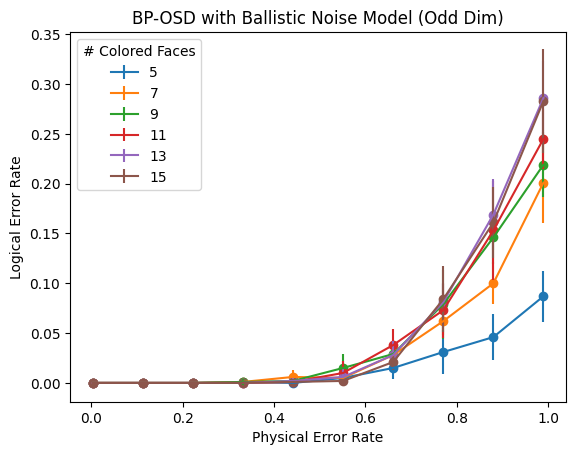

In [10]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')